# Assignment 4: Tracking, Time-resolved microscopy

In [707]:
import diplib as dip
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import string

## Global parameters

In [749]:
img_folder = 'images/'
fn_pattern = 'MTLn3{group}00{num}.tif'
group_names = {'egf': '+egf', 'ctrl': '-ctrl'}

initial_coords = [[334,  85], [103, 122], [325, 155], [416, 426], [168, 116],
                  [413, 150], [80, 221], [80, 249], [336, 254], [80, 327],
                  [422, 359], [194, 378], [391, 396], [206, 419], [100, 421]]

## Functions' definitions

In [515]:
def remove_border_objects(img):
    seed = np.ones(np.array(img.Sizes()) - 2)
    seed = 1 - np.pad(seed, pad_width=1)
    seed = dip.FixedThreshold(dip.Image(seed), 0.5)
    edge_objects = dip.BinaryPropagation(seed, img)
    img -= edge_objects
    return img

def calculate_difference(cell1, cell2):
    distance = (cell1['x_coord'] - cell2['x_coord']) ** 2
    distance += (cell1['y_coord'] - cell2['y_coord']) ** 2
    size_difference = np.abs(cell1['size'] - cell2['size'])
    return np.sqrt(distance) + size_difference

def track_cell(images, segmented, initial_coords, displacement_tolerance=10):
    x_coords, y_coords, sizes = [], [], []
    labeled_archive = []
    x_coords.append(initial_coords[0])
    y_coords.append(initial_coords[1])
    for i in range(30):
        seed = np.zeros(images[0].Sizes())
        x, y = x_coords[-1], y_coords[-1]
        iter_counter = 0
        found_candidates = 0
        offset = displacement_tolerance
        while found_candidates < 1 and iter_counter < 5:
            offset *= 2 ** iter_counter
            seed[x-offset: x+offset, y-offset: y+offset] = 1
            seed = dip.FixedThreshold(seed, 0.5)
            masked = dip.BinaryPropagation(seed, segmented[i])
            labeled = dip.Label(masked, connectivity=1)
            labeled_archive.append(labeled)
            msr = dip.MeasurementTool.Measure(labeled, images[0], ['Gravity', 'Size'])
            chosen_candidate = 1
            found_candidates = msr.NumberOfObjects()
            if found_candidates > 1:
                differences = [calculate_difference({'size': msr['Size'][j+1][0], 'x_coord': msr['Gravity'][j+1][1], 'y_coord': msr['Gravity'][j+1][0]},
                                                    current_cell) for j in range(msr.NumberOfObjects())]
                chosen_candidate = np.argmin(differences) + 1

        y_coord, x_coord = msr['Gravity'][chosen_candidate]
        size = msr['Size'][chosen_candidate][0]
        x_coords.append(int(x_coord))
        y_coords.append(int(y_coord))
        sizes.append(size)
        current_cell = {'size': sizes[-1], 'x_coord': x_coords[-1], 'y_coord': y_coords[-1]}
    return labeled_archive, x_coords, y_coords, sizes

## Data loading and segmentation

In [822]:
images = {'ctrl': {}, 'egf': {}}
for group in images.keys():
    for num in range(30):
        num_str = '0' + str(num) if num < 10 else str(num)
        img = dip.ImageReadTIFF(img_folder + fn_pattern.format(group=group_names[group], num=num_str))
        rescaled_img = img / 2 ** 16 # rescale to [0..1]
        grey_img = dip.ColorSpaceManager.Convert(rescaled_img, 'grey') # convert from RGB to grey-scale
        images[group][num] = grey_img

segmented = {}
for num in images['ctrl'].keys():
    img = images['ctrl'][num]
    bin_img = dip.IsodataThreshold(img) # apply ISODATA threshold
    noe_img = remove_border_objects(bin_img)
    segmented[num] = noe_img

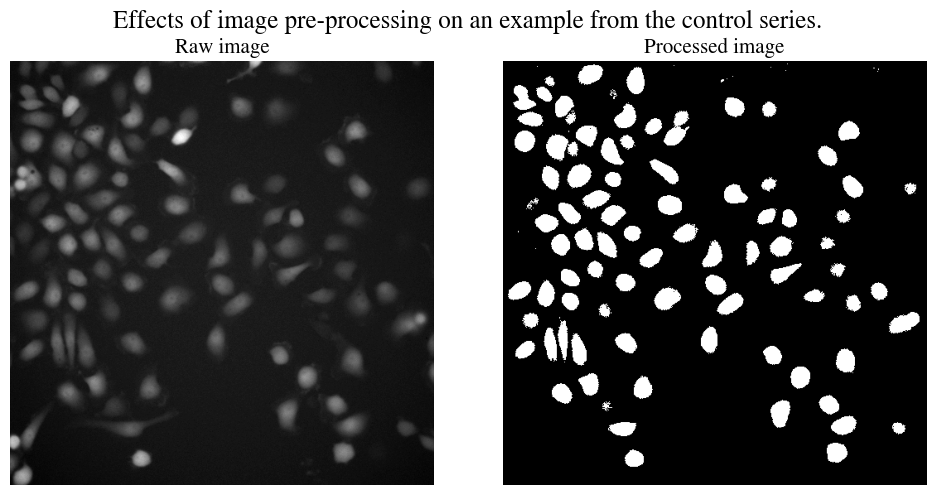

In [840]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
img = dip.ImageReadTIFF('images/MTLn3-ctrl0000.tif')
img = img / 2 ** 16
axs[0].imshow(img, origin='lower', cmap='grey')
axs[0].set_title('Raw image', fontname='STIXGeneral', fontsize=15)
axs[1].imshow(segmented[0], origin='lower', cmap='grey')
axs[1].set_title('Processed image', fontname='STIXGeneral', fontsize=15)
[axs[i].axis('off') for i in range(len(axs))]
fig.suptitle('Effects of image pre-processing on an example from the control series.', fontname='STIXGeneral', fontsize=18)
plt.tight_layout()
plt.savefig('figures/preprocessing.png')

## Computing Accumulative Difference Images (ADIs)

In [519]:
R = images['ctrl'][0]
adi_pos = np.zeros((512, 512))
adi_neg = np.zeros((512, 512))

for i in range(30):
    grad = images['ctrl'][i] - R
    grad_pos, grad_neg = np.copy(grad), np.copy(grad)
    grad_pos[grad_pos > 0.01] = 1
    grad_pos[grad_pos <= 0.01] = 0
    grad_neg[grad_neg >= -0.01] = 0
    grad_neg[grad_neg < -0.01] = 1
    adi_pos += grad_pos
    adi_neg += grad_neg

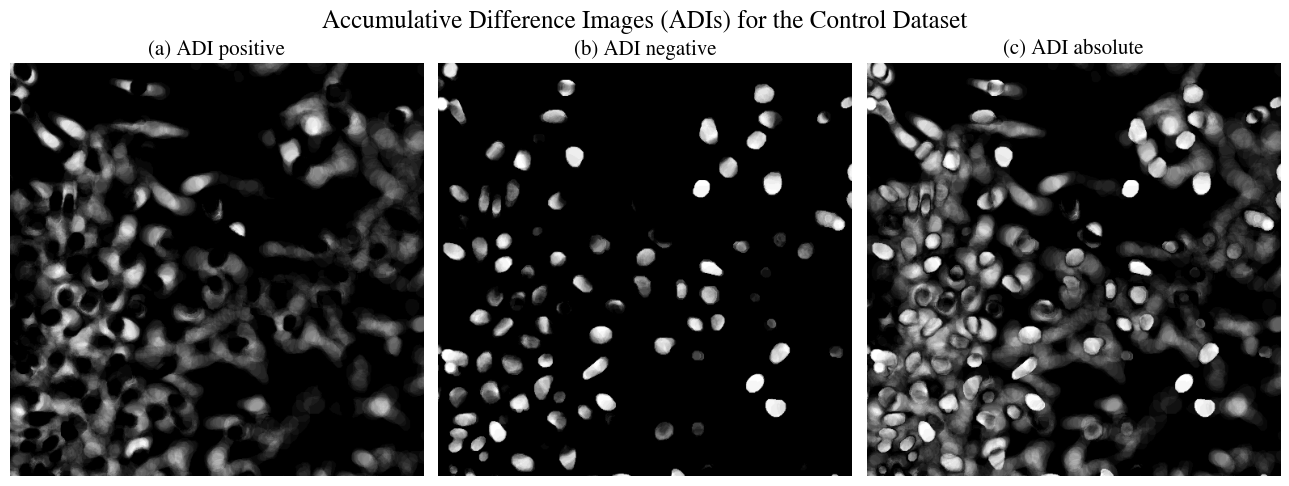

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(13, 5))
axs[0].imshow(adi_pos, cmap='grey')
axs[0].set_title('(a) ADI positive', fontname='STIXGeneral', fontsize=15)
axs[1].imshow(adi_neg, cmap='grey')
axs[1].set_title('(b) ADI negative', fontname='STIXGeneral', fontsize=15)
axs[2].imshow(adi_pos + adi_neg, cmap='grey')
axs[2].set_title('(c) ADI absolute', fontname='STIXGeneral', fontsize=15)

[axs[i].axis('off') for i in range(3)]
fig.suptitle('Accumulative Difference Images (ADIs) for the Control Dataset', fontname='STIXGeneral', fontsize=18)
plt.tight_layout()
plt.savefig('figures/adis.png')

## Cell selection

In [797]:
seed = np.zeros((512, 512))
for coord in initial_coords:
    seed[coord[1], coord[0]] = 1
seed = dip.FixedThreshold(seed, 0.5)
masked = dip.BinaryPropagation(seed, segmented[0])
labeled = dip.Label(masked, connectivity=1)
msr = dip.MeasurementTool.Measure(labeled, images['ctrl'][0], ['Gravity'])
cells = {i+1: [int(msr[i+1]['Gravity'][0]), int(msr[i+1]['Gravity'][1])] for i in range(msr.NumberOfObjects())}
labeled[labeled > 0] = 1

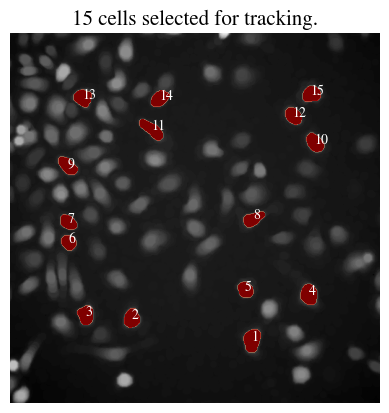

In [800]:
fig, ax = plt.subplots()
ax.imshow(images['ctrl'][0], cmap='grey')
ax.imshow(labeled, alpha=1.0*(labeled>0), cmap='OrRd', origin='lower')
ax.axis('off')
ax.set_title('15 cells selected for tracking.', fontname='STIXGeneral', fontsize=15)
for k in cells.keys():
    ax.annotate(text=k, xy=cells[k], c='w', fontname='STIXGeneral', fontsize=10)
plt.savefig('figures/selected_cells.png')

## Cell tracking

In [703]:
tracked_cells = {}
for i in range(5):
    labeled_archive, x_coords, y_coords, sizes = track_cell(images['ctrl'], segmented, initial_coords[i])
    tracked_cells[i] = {
        'labeled': labeled_archive,
        'x_coords': x_coords,
        'y_coords': y_coords,
        'sizes': sizes
    }

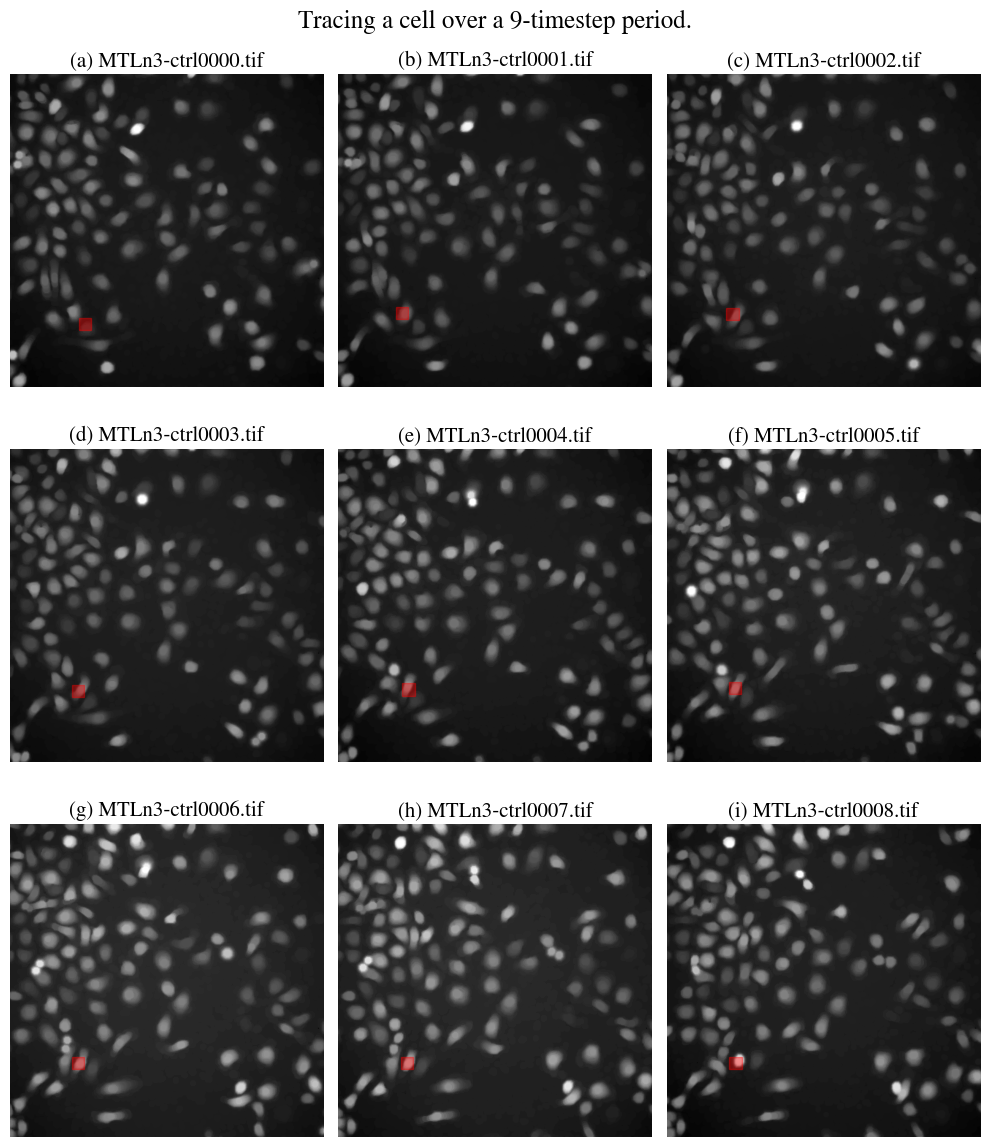

In [725]:
subcaps = string.ascii_lowercase[:9]
fig, axs = plt.subplots(3, 3, figsize=(10, 12))
axs = axs.flatten()
x_coords = tracked_cells[1]['x_coords']
y_coords = tracked_cells[1]['y_coords']
for i in range(len(axs)):
    axs[i].imshow(images['ctrl'][i], origin='lower', cmap='grey')
    rect = Rectangle(xy=(y_coords[i] - 10, x_coords[i] - 10), width=20, height=20, color='r', alpha=0.4)
    axs[i].add_patch(rect)
    axs[i].axis('off')
    num = i if i > 9 else f'0{i}'
    axs[i].set_title(f'({subcaps[i]}) MTLn3-ctrl00{num}.tif', fontname='STIXGeneral', fontsize=15)

fig.suptitle('Tracing a cell over a 9-timestep period.', fontname='STIXGeneral', fontsize=18)
plt.tight_layout()
plt.savefig('figures/single_cell_trace.png')

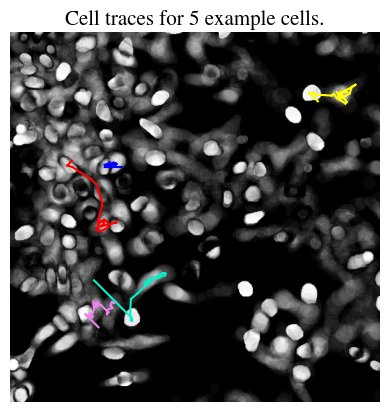

In [714]:
colors = ['r', 'violet', 'b', 'yellow', '#07f0c9']
fig, ax = plt.subplots()
ax.imshow(adi_pos+adi_neg, origin='lower', cmap='grey')
for i in range(5):
    x_coords = tracked_cells[i]['x_coords']
    y_coords = tracked_cells[i]['y_coords']
    for j in range(len(x_coords) - 1):
        ax.plot([y_coords[j], y_coords[j+1]], [x_coords[j], x_coords[j+1]], c=colors[i])
ax.axis('off')
ax.set_title('Cell traces for 5 example cells.', fontname='STIXGeneral', fontsize=15)
plt.savefig('figures/cell_tracking.png')